In [5]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer
from preprocess_evaporation import evaporation_transformer


from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [6]:
df = pd.read_csv('../data/weatherAUS.csv')
city = 'Darwin'

df = df[df['Location'].isin([city])]

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
139111,2008-07-01,Darwin,20.0,33.1,0.0,4.4,11.0,E,41.0,ENE,...,81.0,32.0,1016.0,1012.1,1.0,2.0,25.4,32.3,No,No
139112,2008-07-02,Darwin,19.4,32.4,0.0,6.0,10.4,ENE,50.0,SE,...,81.0,17.0,1016.8,1012.4,1.0,1.0,24.3,31.9,No,No
139113,2008-07-03,Darwin,18.2,31.8,0.0,8.0,11.0,E,46.0,ESE,...,38.0,24.0,1017.2,1013.0,0.0,1.0,24.3,31.2,No,No
139114,2008-07-04,Darwin,17.3,30.7,0.0,7.0,10.4,E,44.0,SE,...,55.0,16.0,1017.3,1013.6,2.0,6.0,21.3,29.8,No,No
139115,2008-07-05,Darwin,15.5,30.8,0.0,7.0,10.8,ESE,46.0,E,...,37.0,16.0,1016.3,1012.6,1.0,1.0,22.2,29.6,No,No


In [40]:
# def preprocessing(url_data : str = '../data/weatherAUS.csv', city : str = 'Sydney'):

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = 'Williamtown'

df = df[df['Location'].isin([city])]

print(df.isna().sum())

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))
if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')
print(df.columns)

df.dropna(inplace = True)
# print('apres', df.info())


Date                0
Location            0
MinTemp             2
MaxTemp             3
Rainfall          456
Evaporation      1063
Sunshine         1654
WindGustDir       136
WindGustSpeed     135
WindDir9am         87
WindDir3pm         18
WindSpeed9am       17
WindSpeed3pm        8
Humidity9am         8
Humidity3pm         7
Pressure9am        12
Pressure3pm        11
Cloud9am          602
Cloud3pm          649
Temp9am             5
Temp3pm             2
RainToday         456
RainTomorrow      456
dtype: int64
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'WindSpeed3pm_std_3', 'WindSpeed3pm_max_3', 'WindSpeed3pm_min_3',
       'WindSpeed3pm_diff', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin'],
      dtype='object', length=117)


In [ ]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
}

poids = y_train.value_counts(normalize = True)


model = LogisticRegression(verbose = 1, C = 1, max_iter = 1000, penalty = 'l1',
                               solver = 'liblinear',
                            intercept_scaling = 0.1, l1_ratio = 0.5, tol = 0.01
                               )

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='f1')

grid_search.fit(X_train_scaled, y_train)

print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

best_model = grid_search.best_estimator_

prob = best_model.predict_proba(X_test_scaled)
y_pred_prob1 = prob[:, 1]

print(y_test.value_counts(normalize = True))

if y_train.value_counts(normalize=True)[1] < 0.15:
    threshold = 0.165
elif y_train.value_counts(normalize=True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]
print(f"Seuil optimal : {threshold}")

y_pred = (y_pred_prob1 > threshold).astype(int)

print('Accuracy score: ', best_model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear]

/home/mathieu/.pyenv/versions/3.10.6/envs/meteo-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 5
iter   5  #CD cycles 1
iter   6  #CD cycles 12
optimization finished, #iter = 6
Objective value = 461.360854
#nonzeros/#features = 63/117
[LibLinear][LibLinear][LibLinear][LibLinear]iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 4
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 1
iter   4  #CD cycles 4
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 1
iter   6  #CD cycles 9
iter   4  #CD cycles 3
optimization finished, #iter = 6
Objective value = 446.606681
#nonzeros/#features = 66/117
iter   4  #CD cycles 4
iter   5  #CD cycles 1
iter   6  #CD cycles 5
iter   5  #CD cycles 1
iter   7  #CD cycles 3
optimization finished, #iter = 7
Objective value = 444.710643
#nonzeros/#features = 66/117
iter   6  #CD c

/home/mathieu/.pyenv/versions/3.10.6/envs/meteo-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/mathieu/.pyenv/versions/3.10.6/envs/meteo-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/mathieu/.pyenv/versions/3.10.6/envs/meteo-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/mathieu/.pyenv/versions/3.10.6/envs/meteo-venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 4
iter   5  #CD cycles 1
iter   6  #CD cycles 11
iter   7  #CD cycles 1
optimization finished, #iter = 7
Meilleurs paramètres trouvés :  {}
Objective value = 561.542931
#nonzeros/#features = 68/117
RainTomorrow
0.0    0.720524
1.0    0.279476
Name: proportion, dtype: float64
Seuil optimal : 0.4047462990579455
Accuracy score:  0.7838427947598253
F1 score:  0.5725490196078431
ROC AUC score:  0.7033380681818182
Brier score:  0.23799126637554585 


[[276  54]
 [ 55  73]] 


              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       330
         1.0       0.57      0.57      0.57       128

    accuracy                           0.76       458
   macro avg       0.70      0.70      0.70       458
weighted avg       0.76      0.76      0.76       458



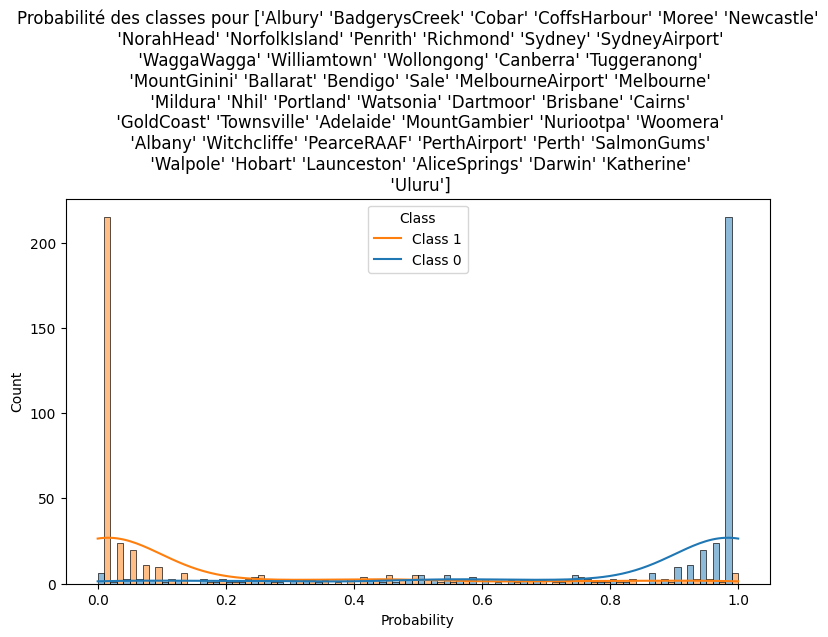

In [36]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.histplot(prob, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1', 'Class 0'], loc='upper center')
plt.title(f'Probabilité des classes pour {city}')
plt.show()


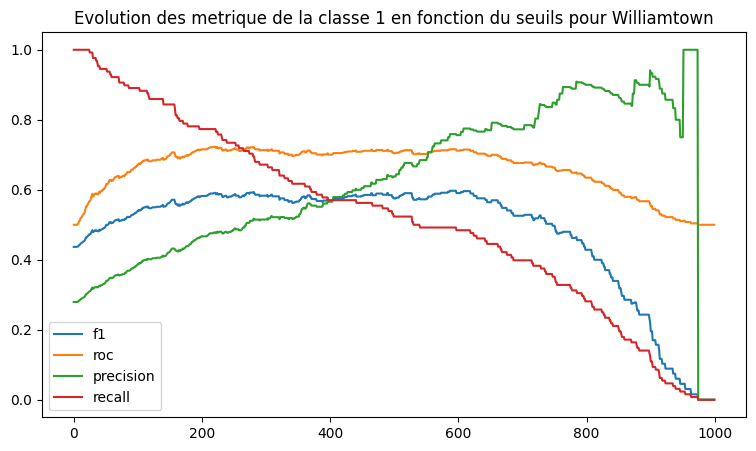

In [42]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred = (y_pred_prob1 > i).astype("int32")

    f1_1.append(f1_score(y_test, y_pred))
    roc_1.append(roc_auc_score(y_test, y_pred))
    precision1.append(precision_score(y_test, y_pred))
    recall1.append(recall_score(y_test, y_pred))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.title(f'Evolution des metrique de la classe 1 en fonction du seuils pour {city}')
plt.legend()

plt.show()

In [ ]:
df = pd.read_csv('../data/weatherAUS.csv')


print(df['Location'].unique())

In [ ]:

df_1 = pd.read_csv('../data/weatherAUS.csv')

list_city = []
list_accuracy = []
list_f1 = []
list_recall = []
list_precision = []
list_roc = []

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = df_1['Location'].unique()
print(city)
for i in city:
    print('la ville -----------------', i)

    df = df_1[df_1['Location'].isin([i])]

    columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

    # print('colonne drop', columns_to_drop)
    # print('colonne du dataframe', df.columns)

    transformers = []
    if 'Evaporation' not in columns_to_drop:
        transformers.append(('evaporation_transformer', evaporation_transformer()))
    if 'Sunshine' not in columns_to_drop:
        transformers.append(('sunshine_transformer', sunshine_transformer()))
    if 'RainTomorrow' not in columns_to_drop:
        transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
    if 'Date' not in columns_to_drop:
        transformers.append(('date_transformer', preprocess_date_transformer()))
    for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
        if temp_col not in columns_to_drop:
            transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
    for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
        if wind_col not in columns_to_drop:
            transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
    for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        if wind_dir_col not in columns_to_drop:
            transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
    if 'Rainfall' not in columns_to_drop:
        transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
    for humidity_col in ['Humidity9am', 'Humidity3pm']:
        if humidity_col not in columns_to_drop:
            transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
    for pressure_col in ['Pressure9am', 'Pressure3pm']:
        if pressure_col not in columns_to_drop:
            transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

    df_transformed = Pipeline(transformers).fit_transform(df)

    df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
    df = df.set_index('Date')
    print(df.columns)

    df.dropna(inplace = True)


    X = df.drop(columns = 'RainTomorrow')
    y = df['RainTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

    scaler = MinMaxScaler(feature_range = (-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = LogisticRegression(verbose = 1, C = 1, max_iter = 1000, penalty = 'l1',
                               solver = 'liblinear',
                               intercept_scaling = 0.1, l1_ratio = 0.5, tol = 0.01)


    model.fit(X_train_scaled, y_train)

    print(y_train.value_counts(normalize = True))
    print(y_train.value_counts())

    prob = model.predict_proba(X_test_scaled)

    y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

    if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
    if y_train.value_counts(normalize = True)[1] > 0.30:
        threshold = 0.85
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
        diff = abs(precision - recall)
        threshold = thresholds[diff.argmin()]
    print(threshold)


    y_pred = (y_pred_prob1 > threshold).astype(int)

    list_city.append(i)

    list_accuracy.append(model.score(X_test_scaled, y_test))
    list_f1.append(f1_score(y_test, y_pred))
    list_roc.append(roc_auc_score(y_test, y_pred))
    list_precision.append(precision_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))


['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
la ville ----------------- Albury
Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'WindSpeed3pm_std_3', 'WindSpeed3pm_max_3', 'WindSpeed3pm_min_3',
       'WindSpeed3pm_diff', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'Win

In [44]:
df_global = pd.DataFrame({
    'location' : list_city,
    'accurcy' : list_accuracy,
    'f1': list_f1,
    'roc' : list_roc,
    'precision' : list_precision,
    'recall' : list_recall}
)

df_global.set_index('location', inplace = True)


df_global.to_csv('../data_saved/first_result_evap.csv')

In [45]:
df_global.mean(axis = 0)

accurcy      0.855802
f1           0.612246
roc          0.754077
precision    0.691717
recall       0.586127
dtype: float64

In [28]:
df_global

,accurcy,f1,roc,precision,recall
location,,,,,
Albury,0.833780,0.636066,0.770619,0.638158,0.633987
BadgerysCreek,0.825000,0.629213,0.768561,0.631579,0.626866
Cobar,0.842697,0.631579,0.785089,0.635294,0.627907
CoffsHarbour,0.764244,0.467213,0.642168,0.760000,0.337278
Moree,0.886562,0.654545,0.796730,0.658537,0.650602
Newcastle,0.665702,0.519174,0.681088,0.520710,0.517647
NorahHead,0.774687,0.663291,0.767468,0.664975,0.661616
NorfolkIsland,0.773876,0.555224,0.689051,0.823009,0.418919
Penrith,0.819972,0.636042,0.772086,0.638298,0.633803
